In [1]:
# 导入cv2 和 matplotlib
import cv2
import numpy as np
print(cv2.__version__)
print(np.__version__)

4.7.0
1.24.3


In [2]:
# 导入地平线的多媒体库
from hobot_vio import libsrcampy as srcampy

In [3]:
# jupyter显示图像的函数，能显示cv2的彩色图和灰度图，这个在上节有出现过
# 缺省值为图像大小
from  matplotlib import pyplot as plt
%matplotlib inline
def cv2_img2plt_img(cv2_img):
    if len(cv2_img)==3:  # 彩图
        return cv2_img# [:,:,::-1]
    else:                # 灰度图
        return cv2_img
def jshow(cv2_img, size=4):
    plt.figure(figsize=(size, size))
    plt.imshow(cv2_img2plt_img(cv2_img), plt.cm.gray)
    plt.show()

In [4]:
# 新建一个mipi相机对象
cap_mipi = srcampy.Camera()
# 设置X3派相机参数
height, width = 1440, 2560
ret = cap_mipi.open_cam(0, -1, 30, width, height)

2023/10/17 15:00:55.748 !INFO [x3_cam_init_param][0099]Enable mipi host0 mclk
2023/10/17 15:00:55.748 !INFO [x3_cam_init_param][0099]Enable mipi host1 mclk


In [31]:
# 由于不是正常在循环中使用摄像头，故需要跳过一些缓冲区中的帧
for i in range(15):
     cap_mipi.get_img(2, width, height)
# 获取相机的数据流
mipi_data = cap_mipi.get_img(2, width, height)

In [6]:
# 我们一起来看看从摄像头获取的数据流是什么
print(type(mipi_data))

<class 'bytes'>


In [32]:
%%time
# 看起来是一些bytes，我们一起来转化成numpy数组
mipi_img = np.frombuffer(mipi_data, dtype=np.uint8)
print(mipi_img.shape)

(5529600,)
CPU times: user 767 µs, sys: 101 µs, total: 868 µs
Wall time: 771 µs


In [8]:
# 按照/app/pydev_demo/03_mipi_camera_sample/mipi_camera.py 的demo
# 这是nv12格式的图片，可以直接送入bpu推理了，可以看到这个处理非常迅速
# 此处将此nv12格式的图片转成cv2的的RGB格式图片，存储在numpy数组中，并进行可视化看看
# mipi的nv12格式图片 转 cv2的rgb格式图片
def mipi_img2cv2_img(mipi_img, height, width):
    # 按照nv12的格式进行排布
    mipi_img = mipi_img.reshape(int(1.5*height), width)
    # 利用cv2的函数进行格式转换
    cv2_img = cv2.cvtColor(mipi_img, cv2.COLOR_YUV420SP2BGR) 
    return cv2_img

(1440, 2560, 3)


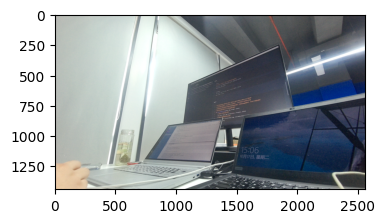

In [33]:
# 我们看看从mipi摄像头获得的图像
cv2_img = mipi_img2cv2_img(mipi_img, height, width)
print(cv2_img.shape)
jshow(cv2_img)

In [32]:
# 这就是从mipi摄像头获得的图像了，可以转为为rgb格式，
# 并使用cv2的imwrite方法存储到本地的png格式
# 这里转换了一下BGR和RGB，具体的原因也不清楚，这样保证jupyter的显示和保存颜色都是正常的
ret = cv2.imwrite("./mipi_camera_picture.png", cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
print(ret)

True


In [ ]:
# 用完记得关闭摄像头，回收资源
cap_mipi.close_cam()